# 11-MobileNetV2

[1.Set hyper parameters & DataLoader](#1)

[2.BottleNeck Residual Block(Inverted Residual Block)](#2)

[3.MobileNetV2](#3)

[4.Training](#4)

In [1]:
import os
import cv2
import torch
import albumentations as A
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from torchsummary import summary
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

<a id="1"></a>
## 1.Set hyper parameters & DataLoader

In [2]:
data_dir = "/home/pervinco/Datasets/mammals-classification/data"
save_dir = "./runs/mammal-classification/resnet"

epochs = 500
batch_size = 64

learning_rate = 0.001
lr_patience = 10
lr_decay_rate = 0.1 ## 0.98
weight_decay = 0.00002

early_stop_counter = 0
early_stop_patience = 30

num_workers = os.cpu_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
classes = sorted(os.listdir(data_dir))
print(classes)

images, labels = [], []
for str_label in classes:
    img_files = os.listdir(f"{data_dir}/{str_label}")
    for file in img_files:
        if file.endswith(".jpg"):
            images.append(f"{data_dir}/{str_label}/{file}")
            labels.append(str_label)

print(f"Num of Classes : {len(classes)}")
print(f"Num of files & labels : {len(images)}, {len(labels)}")
print(images[0])

train_x, valid_x, train_y, valid_y = train_test_split(images, labels, test_size=0.1, shuffle=True, random_state=42)

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

['african_elephant', 'alpaca', 'american_bison', 'anteater', 'arctic_fox', 'armadillo', 'baboon', 'badger', 'blue_whale', 'brown_bear', 'camel', 'dolphin', 'giraffe', 'groundhog', 'highland_cattle', 'horse', 'jackal', 'kangaroo', 'koala', 'manatee', 'mongoose', 'mountain_goat', 'opossum', 'orangutan', 'otter', 'polar_bear', 'porcupine', 'red_panda', 'rhinoceros', 'sea_lion', 'seal', 'snow_leopard', 'squirrel', 'sugar_glider', 'tapir', 'vampire_bat', 'vicuna', 'walrus', 'warthog', 'water_buffalo', 'weasel', 'wildebeest', 'wombat', 'yak', 'zebra']
Num of Classes : 45
Num of files & labels : 13751, 13751
/home/pervinco/Datasets/mammals-classification/data/african_elephant/african_elephant-0125.jpg
12375 12375
1376 1376


In [4]:
class MammalDataset(Dataset):
    def __init__(self, images, labels, classes, mean=None, std=None, augmentation=False):
        self.classes = classes
        self.images = images
        self.labels = labels

        if mean is None:
            mean = (0.485, 0.456, 0.406)

        if std is None:
            std = (0.229, 0.224, 0.225)

        if augmentation:
            self.augmentation = A.Compose([
                A.OneOf([
                    A.Resize(224, 224, p=0.5),
                    A.SmallestMaxSize(max_size=[256, 512], p=0.5)
                ], p=1),
                A.RandomCrop(width=224, height=224),

                A.HorizontalFlip(p=0.4),
                A.RGBShift(p=0.3),

                A.ShiftScaleRotate(p=1.0, shift_limit_x=(-0.06, 0.06), shift_limit_y=(-0.06, 0.06), 
                                   scale_limit=(-0.099, 0.100), 
                                   rotate_limit=(-180, 180), 
                                   interpolation=0, 
                                   border_mode=0, 
                                   value=(0, 0, 0)),
                A.RandomBrightnessContrast(p=1.0, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
                A.AdvancedBlur(p=0.35, blur_limit=(3, 7), 
                               sigmaX_limit=(0.2, 1.0), 
                               sigmaY_limit=(0.2, 1.0), 
                               rotate_limit=(-90, 90), 
                               beta_limit=(0.5, 8.0), 
                               noise_limit=(0.9, 1.1)),

                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ])
        else:
            self.augmentation = A.Compose([
                A.Resize(224, 224, p=1),
                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ])


    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.classes.index(label)

        image = self.augmentation(image=image)["image"]

        return image, label

In [5]:
train_dataset = MammalDataset(train_x, train_y, classes, augmentation=True)
valid_dataset = MammalDataset(valid_x, valid_y, classes, augmentation=False)
train_dataloder = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers)

<a id="2"></a>
## 1.BottleNeck Residual Block(Inverted Residual Block)

Manifold of Interest에 따라, 고차원의 데이터에서 핵심적인 feature는 저차원 공간에 존재하는 값일 수 있다.  
BottleNeck Residual Block은 고차원의(Expanded) 값에서 manifold를 포착하고, BottleNeck에 의해 차원이 작아져도 포착한 특성이 그대로 유지될 수 있음을 기반으로 한다.

따라서 Depth를 증가시켜 차원과 비선형성을 증가시키는 것보다 계산적으로 훨씬 효율적이다.

In [6]:
class InvertedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super().__init__()
        self.stride=stride
        self.shortcut_connection = self.stride == 1 and in_channels == out_channels

        if expand_ratio > 1:
            self.inverted_residual_block = nn.Sequential(
                ## Expand - Pointwise convolution, h * w * t ---> h * w * tk
                nn.Conv2d(in_channels=in_channels, 
                          out_channels=in_channels * expand_ratio, 
                          kernel_size=1,
                          stride=1, 
                          padding=0,
                          bias=False),
                nn.BatchNorm2d(in_channels * expand_ratio),
                nn.ReLU6(inplace=True),

                ## Depthwise Convolution
                nn.Conv2d(in_channels=in_channels * expand_ratio,
                          out_channels=in_channels * expand_ratio,
                          kernel_size=3,
                          stride=stride,
                          padding=1,
                          groups=in_channels * expand_ratio,
                          bias=False),

                ## BottleNeck - Pointwise convolution, h * w * tk ---> h * w * k'
                nn.Conv2d(in_channels=in_channels * expand_ratio,
                          out_channels=out_channels,
                          kernel_size=1,
                          stride=1,
                          padding=0,
                          bias=False),
                nn.BatchNorm2d(out_channels)
            )

        else:
            self.inverted_residual_block = nn.Sequential(
                ## expand_ratio가 1일 때 Expand pointwise convolution은 의미가 없으므로 적용하지 않음.
                ## Depthwise Convolution
                nn.Conv2d(in_channels=in_channels, 
                          out_channels=in_channels,
                          kernel_size=3,
                          stride=stride,
                          padding=1,
                          groups=in_channels,
                          bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU6(inplace=True),

                ## BottleNeck - Pointwise Convolution
                nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels,
                          kernel_size=1,
                          stride=1,
                          padding=0,
                          bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        if self.shortcut_connection:
            return x + self.inverted_residual_block(x)
        else:
            return self.inverted_residual_block(x)


<a id="3"></a>
## 2.MobileNetV2

In [7]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1000, width_multiplier=1.0, init_weights=True):
        super(MobileNetV2, self).__init__()
        self.configs = [
            ## t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]
        
        ## First layer
        self.first_layer = nn.Sequential(
            nn.Conv2d(3, int(32 * width_multiplier), kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(int(32 * width_multiplier)),
            nn.ReLU6(inplace=True)
        )
        
        ## Inverted residual blocks
        ## 하나의 블록이 여러 번 쌓는 구조를 만들기 위함.
        self.inverted_residual_blocks = nn.ModuleList()
        input_channels = int(32 * width_multiplier)
        for t, c, n, s in self.configs:
            output_channels = int(c * width_multiplier)
            for i in range(n): ## n번 실행.
                if i == 0:
                    self.inverted_residual_blocks.append(
                        InvertedResidualBlock(input_channels, output_channels, s, expand_ratio=t))
                else:
                    self.inverted_residual_blocks.append(
                        InvertedResidualBlock(input_channels, output_channels, 1, expand_ratio=t))
                input_channels = output_channels
        
        ## Last layers
        self.last_layers = nn.Sequential(
            nn.Conv2d(input_channels, int(1280 * width_multiplier), kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(int(1280 * width_multiplier)),
            nn.ReLU6(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(int(1280 * width_multiplier), num_classes)
        )

        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.first_layer(x)
        for block in self.inverted_residual_blocks:
            x = block(x)
        x = self.last_layers(x)
        
        return x

<a id="4"></a>
## 4.Training

In [8]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()

    train_cost, train_acc = 0.0, 0.0
    for x, y in tqdm(dataloader, desc="Train", leave=False):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)

        cost = criterion(y_pred, y)
        cost.backward()
        optimizer.step()

        train_cost += cost.item() * x.size(0)

        _, pred_labels = torch.max(y_pred, 1)
        train_acc += (pred_labels == y).sum().item()

    train_cost /= len(dataloader.dataset)
    train_acc /= len(dataloader.dataset)

    return train_cost, train_acc


def valid(model, dataloader, criterion, device):
    model.eval()

    valid_cost, valid_acc = 0.0, 0.0
    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Valid", leave=False):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            cost = criterion(y_pred, y)

            valid_cost += cost.item() * x.size(0)

            _, pred_labels = torch.max(y_pred, 1)
            valid_acc += (pred_labels == y).sum().item()

        valid_cost /= len(dataloader.dataset)
        valid_acc /= len(dataloader.dataset)

    return valid_cost, valid_acc

def lr_lambda(epoch):
    return lr_decay_rate ** epoch

In [9]:
model = MobileNetV2(num_classes=len(classes), width_multiplier=1.0, init_weights=True)
summary(model, input_size=(3, 224, 224), device="cpu")
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
InvertedResidualBlock-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
           Conv2d-14           [-1, 

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# scheduler = LambdaLR(optimizer, lr_lambda)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_rate, patience=lr_patience, verbose=True)

lrs = []
train_costs, train_accs = [], []
valid_costs, valid_accs = [], []
best_valid_cost = float('inf')
for epoch in range(epochs):
    train_cost, train_acc = train(model, train_dataloder, criterion, optimizer, device)
    valid_cost, valid_acc = valid(model, valid_dataloader, criterion, device)

    if epoch % 10 == 0 or epoch == epochs:
        print(f"Epoch : {epoch} | {epochs}")
        print(f"\tTrain Loss : {train_cost:.4f}, Train Acc : {train_acc:.4f}")
        print(f"\tValid Loss : {valid_cost:.4f}, Valid Acc : {valid_acc:.4f}")

    train_costs.append(train_cost)
    valid_costs.append(valid_cost)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    
    lrs.append(optimizer.param_groups[0]['lr'])
    # scheduler.step()
    scheduler.step(valid_cost)

    ## Early Stopping
    if valid_cost < best_valid_cost:
        best_valid_cost = valid_cost
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping triggered after epoch {epoch} due to no improvement in validation loss")
        break  # Break out of the loop to stop training

Epoch : 0 | 500
	Train Loss : 3.6332, Train Acc : 0.0661
	Valid Loss : 3.4820, Valid Acc : 0.1076


Epoch : 10 | 500
	Train Loss : 2.9768, Train Acc : 0.2039
	Valid Loss : 2.9607, Valid Acc : 0.2151


Epoch : 20 | 500
	Train Loss : 2.5549, Train Acc : 0.3103
	Valid Loss : 2.6648, Valid Acc : 0.3016


Epoch : 30 | 500
	Train Loss : 2.2134, Train Acc : 0.3901
	Valid Loss : 2.0935, Valid Acc : 0.4390


Epoch : 40 | 500
	Train Loss : 1.9638, Train Acc : 0.4514
	Valid Loss : 1.8205, Valid Acc : 0.5145


Epoch : 50 | 500
	Train Loss : 1.7516, Train Acc : 0.5147
	Valid Loss : 1.5848, Valid Acc : 0.5429


Epoch : 60 | 500
	Train Loss : 1.5439, Train Acc : 0.5594
	Valid Loss : 1.6226, Valid Acc : 0.5574


Epoch : 70 | 500
	Train Loss : 1.4070, Train Acc : 0.6028
	Valid Loss : 1.3073, Valid Acc : 0.6286


Epoch : 80 | 500
	Train Loss : 1.2743, Train Acc : 0.6398
	Valid Loss : 1.2920, Valid Acc : 0.6475


Epoch : 90 | 500
	Train Loss : 1.1595, Train Acc : 0.6659
	Valid Loss : 1.1494, Valid Acc : 0.6686


Epoch 00094: reducing learning rate of group 0 to 1.0000e-04.


Epoch : 100 | 500
	Train Loss : 0.8839, Train Acc : 0.7534
	Valid Loss : 0.9183, Valid Acc : 0.7398


Epoch : 110 | 500
	Train Loss : 0.8442, Train Acc : 0.7619
	Valid Loss : 0.8943, Valid Acc : 0.7376


Epoch : 120 | 500
	Train Loss : 0.8046, Train Acc : 0.7683
	Valid Loss : 0.8816, Valid Acc : 0.7456


Epoch : 130 | 500
	Train Loss : 0.7840, Train Acc : 0.7766
	Valid Loss : 0.8624, Valid Acc : 0.7456


Epoch : 140 | 500
	Train Loss : 0.7605, Train Acc : 0.7848
	Valid Loss : 0.8828, Valid Acc : 0.7558


Epoch 00144: reducing learning rate of group 0 to 1.0000e-05.


Epoch : 150 | 500
	Train Loss : 0.7246, Train Acc : 0.7926
	Valid Loss : 0.8693, Valid Acc : 0.7580


Epoch : 160 | 500
	Train Loss : 0.7358, Train Acc : 0.7897
	Valid Loss : 0.8515, Valid Acc : 0.7573


Epoch 00169: reducing learning rate of group 0 to 1.0000e-06.


Epoch : 170 | 500
	Train Loss : 0.7295, Train Acc : 0.7932
	Valid Loss : 0.8639, Valid Acc : 0.7638


Epoch : 180 | 500
	Train Loss : 0.7309, Train Acc : 0.7940
	Valid Loss : 0.8595, Valid Acc : 0.7573


Epoch 00189: reducing learning rate of group 0 to 1.0000e-07.


Epoch : 190 | 500
	Train Loss : 0.7290, Train Acc : 0.7935
	Valid Loss : 0.8571, Valid Acc : 0.7594


Epoch : 200 | 500
	Train Loss : 0.7384, Train Acc : 0.7851
	Valid Loss : 0.8692, Valid Acc : 0.7580


Epoch 00205: reducing learning rate of group 0 to 1.0000e-08.


Epoch : 210 | 500
	Train Loss : 0.7291, Train Acc : 0.7915
	Valid Loss : 0.8447, Valid Acc : 0.7616


Epoch : 220 | 500
	Train Loss : 0.7016, Train Acc : 0.8005
	Valid Loss : 0.8577, Valid Acc : 0.7587


Early stopping triggered after epoch 223 due to no improvement in validation loss


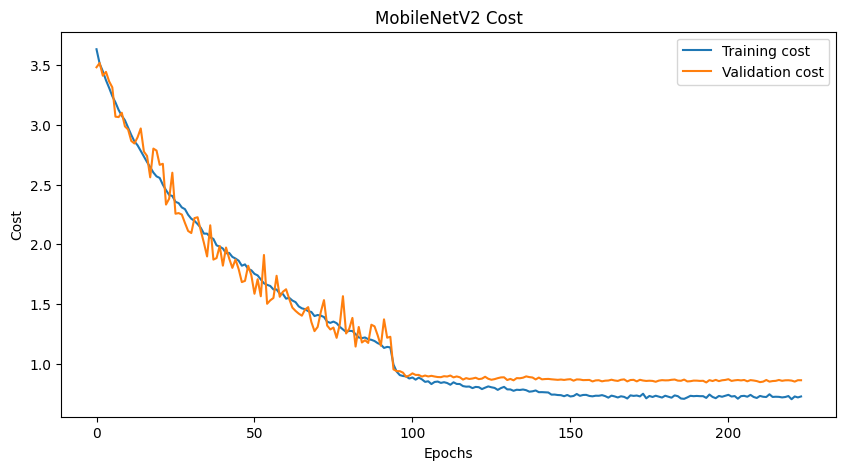

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(train_costs, label='Training cost')
plt.plot(valid_costs, label='Validation cost')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.title('MobileNetV2 Cost')
plt.show()

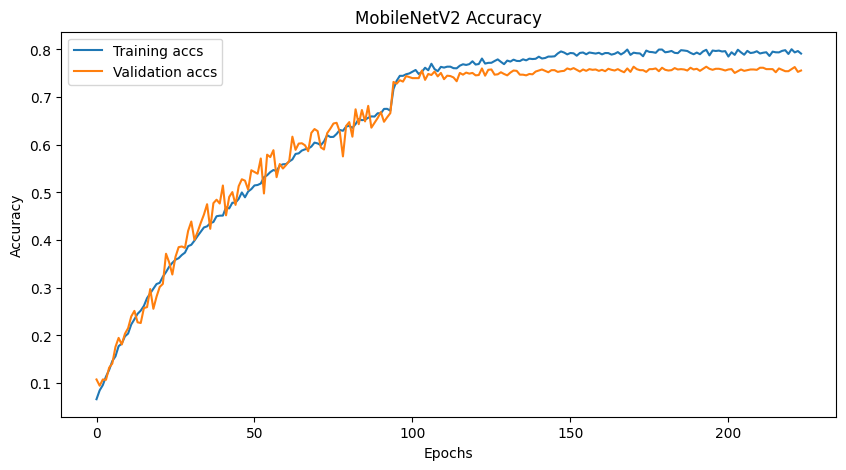

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training accs')
plt.plot(valid_accs, label='Validation accs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('MobileNetV2 Accuracy')
plt.show()

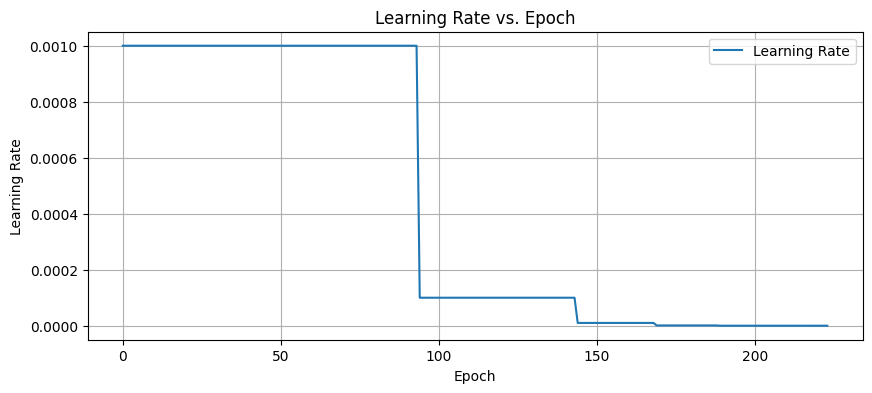

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(lrs, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()